In [1]:
from IPython.display import clear_output

import os, glob
from pathlib import Path
import gc

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode

from torchmetrics.functional import pairwise_cosine_similarity

In [2]:
assert torch.cuda.is_available()

gc.collect()
torch.cuda.empty_cache()

cuda = torch.device("cuda:8")

In [3]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
#!unzip -q tiny-imagenet-200.zip


In [4]:
# dataset_parameters
num_labels = 200
input_shape = [3, 64, 64]
num_train_data = 100000
num_test_data = 10000
batch_size = 50
dataset_loc = './tiny-imagenet-200'
dataset_name = 'tiny-imagenet-200'
per_label_array = [10, 20, 30, 40, 50]

In [5]:
id_dict = {}
for i, line in enumerate(open(dataset_loc + "/wnids.txt", "r")):
    id_dict[line.replace("\n", "")] = i

label_dict = {}
for i, line in enumerate(open(dataset_loc + "/words.txt", "r")):
    line = line.replace("\n", "")
    n_id, word = line.split("\t")[:2]
    if n_id in id_dict.keys():
        label_id = id_dict[n_id]
        label_dict[label_id] = word

for label_id in label_dict.keys():
    print(label_id, label_dict[label_id])

22 goldfish, Carassius auratus
55 European fire salamander, Salamandra salamandra
5 bullfrog, Rana catesbeiana
183 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
160 American alligator, Alligator mississipiensis
177 boa constrictor, Constrictor constrictor
174 trilobite
125 scorpion
141 black widow, Latrodectus mactans
43 tarantula
161 centipede
67 goose
68 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
94 jellyfish
164 brain coral
33 snail
100 slug
165 sea slug, nudibranch
151 American lobster, Northern lobster, Maine lobster, Homarus americanus
89 spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
115 black stork, Ciconia nigra
41 king penguin, Aptenodytes patagonica
35 albatross, mollymawk
116 dugong, Dugong dugon
182 Chihuahua
135 Yorkshire terrier
78 golden retriever
39 Labrador retriever
11 German shepherd, German shepherd dog, German police dog, alsatian
194 standard poodle
66 tabby, tabby cat
131 Persian cat
0 Egypti

In [6]:
def roundup(x, base_index=1):
    return math.ceil(x / pow(10, base_index)) * pow(10, base_index)


def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )


def move_to_device(tensors, device):
    if type(tensors) is tuple:
        return tuple(tensor.to(device) for tensor in tensors)
    return tensors.to(device)

In [7]:
class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob(dataset_loc + "/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)

        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.id_dict[img_path.split("/")[5].split("_")[0]]

        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

In [8]:
class PartitionDataset(Dataset):
    def __init__(self, location_str, label):
        self.label = label
        self.location_str = location_str
        self.filename = location_str + str(label) + ".pt"
        data_tensor = torch.load(self.filename)
        self.dataset_len = len(data_tensor)
        del data_tensor

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        data_tensor = torch.load(self.filename)
        return data_tensor[idx]

In [9]:
class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob(dataset_loc + "/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open(dataset_loc + "/val/val_annotations.txt", "r")):
            a = line.split("\t")
            img, cls_id = a[0], a[1]
            self.cls_dic[img] = self.id_dict[cls_id]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)

        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.cls_dic[img_path.split("/")[-1]]

        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

In [10]:
def load_data():
    transform = transforms.Normalize(
        (122.4786, 114.2755, 101.3963), (70.4924, 68.5679, 71.8127)
    )

    trainset = TrainTinyImageNetDataset(id=id_dict, transform=transform)
    testset = TestTinyImageNetDataset(id=id_dict, transform=transform)
    
    train_images = torch.zeros([num_train_data] + input_shape)
    train_labels = torch.ones(num_train_data)

    test_images = torch.zeros([num_test_data] + input_shape)
    test_labels = torch.ones(num_test_data)

    for index in range(num_train_data):
        train_images[index], train_labels[index] = trainset[index]

    for index in range(num_test_data):
        test_images[index], test_labels[index] = testset[index]
    
    del trainset, testset
    
    return train_images, train_labels, test_images, test_labels

In [11]:
def save_class_partition(train_images, train_labels, test_images, test_labels):
    train_image_partition = dict()
    test_image_partition = dict()

    for label in range(num_labels):
        base_train_str = (
            dataset_loc + "/train/train_class_partition_" + str(label) + ".pt"
        )
        base_test_str = dataset_loc + "/test/test_class_partition_" + str(label) + ".pt"

        train_image_partition[label] = train_images[train_labels == label]
        test_image_partition[label] = test_images[test_labels == label]

        torch.save(train_image_partition[label], base_train_str)
        torch.save(test_image_partition[label], base_test_str)


def load_class_partition(label=None, train=True):
    if train:
        base_str = dataset_loc + "/train/train_class_partition_"
    else:
        base_str = dataset_loc + "/test/test_class_partition_"

    if label is not None:
        base_str += str(label) + ".pt"
        return torch.load(base_str, map_location='cpu')
    else:
        class_partition = dict()
        for label in range(num_labels):
            class_partition[label] = torch.load(
                base_str + str(label) + ".pt", map_location="cpu"
            )

        return class_partition

In [12]:
def plot_images(images, labels, num_images=4):
    assert len(images) == len(labels)
    num_data = len(images)
    start = torch.randint(0, num_data - num_images - 1, (1,)).item()

    label_str = ""
    for i in range(num_images):
        label_str += label_dict[labels[start + i].item()] + "\n"
    print(label_str)

    img_select = images[start : start + num_images]
    for i in range(num_images):
        img_min = img_select[i].min()
        img_max = img_select[i].max()
        img_select[i].clamp_(min=img_min, max=img_max)
        img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
    img = torchvision.utils.make_grid(img_select, nrow=num_images)
    
    if img.is_cuda:
        img = img.cpu()
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img.permute(1, 2, 0))

In [13]:
#train_images, train_labels, test_images, test_labels = load_data()

#plot_images(train_images, train_labels)

#plot_images(test_images, test_labels)

#train_images, train_labels = move_to_device((train_images, train_labels), cuda)
#test_images, test_labels = move_to_device((test_images, test_labels), cuda)
#del train_images, train_labels, test_images, test_labels

In [14]:
# train_class_partition = load_class_partition(train=True)
test_class_partition = load_class_partition(train=False)

In [15]:
print(test_class_partition[0].get_device())

-1


In [16]:
def get_greedy_subset_partition(domain, num_points):
    domain = domain.to(device=cuda)
    domain_flat = torch.flatten(domain, start_dim=1)

    # flat_shape = domain_flat.shape[1:]
    # subset_shape = [num_points, flat_shape]
    subset_shape = [num_points] + input_shape

    subset_domain = torch.zeros(subset_shape, device=cuda)
    # random initialization
    rand_index = torch.randint(0, len(domain), (1,)).item()
    subset_domain[0] = domain[rand_index]

    for index in range(1, num_points):
        sim = pairwise_cosine_similarity(
            domain_flat, torch.flatten(subset_domain[:index], start_dim=1)
        )
        max_sim = torch.max(sim, dim=1).values
        selected_index = torch.argmin(max_sim).item()
        subset_domain[index] = domain[selected_index]
    return subset_domain


def save_greedy_partition(image_partition, per_label, train=True):
    dir_path = ""
    if train:
        dir_path += dataset_loc + "/train"
    else:
        dir_path += dataset_loc + "/test"
    dir_path += "/greedy"
    dir_path += "/per_label_" + str(per_label)
    Path(dir_path).mkdir(parents=True, exist_ok=True)

    file_path = "/greedy_partition_"

    greedy_class_partition_first_half = dict()
    greedy_class_partition_second_half = dict()

    max_data_size = int(0.5 * per_label * 10)
    half = int(0.5 * len(image_partition[0]))
    assert max_data_size <= half

    for label in range(num_labels):
        if label % 10 == 0:
            print("Finding greedy partition for label " + str(label))

        greedy_class_partition_first_half[label] = get_greedy_subset_partition(
            image_partition[label][:max_data_size], per_label // 2
        )
        greedy_class_partition_second_half[label] = get_greedy_subset_partition(
            image_partition[label][half : half + max_data_size], per_label // 2
        )

        torch.save(
            greedy_class_partition_first_half[label],
            dir_path + file_path + "first_half_" + str(label) + ".pt",
        )

        torch.save(
            greedy_class_partition_second_half[label],
            dir_path + file_path + "second_half_" + str(label) + ".pt",
        )
    return greedy_class_partition_first_half, greedy_class_partition_second_half


def load_greedy_partition(per_label, label=None, train=True):
    dir_path = ""
    if train:
        dir_path += dataset_loc + "/train"
    else:
        dir_path += dataset_loc + "/test"
    dir_path += "/greedy"
    dir_path += "/per_label_" + str(per_label)

    file_path_first_half = "/greedy_partition_first_half_"
    file_path_second_half = "/greedy_partition_second_half_"

    if label is not None:
        first_half = torch.load(
            dir_path + file_path_first_half + str(label) + ".pt", map_location="cpu"
        )
        second_half = torch.load(
            dir_path + file_path_second_half + str(label) + ".pt", map_location="cpu"
        )
        return first_half, second_half
    else:
        shape = [num_labels, per_label//2] + input_shape
        class_partition_first_half = torch.zeros(shape)
        class_partition_second_half = torch.zeros(shape)

        for label in range(num_labels):
            class_partition_first_half[label] = torch.load(
                dir_path + file_path_first_half + str(label) + ".pt",
                map_location="cpu"
            )
            class_partition_second_half[label] = torch.load(
                dir_path + file_path_second_half + str(label) + ".pt",
                map_location="cpu",
            )

        return class_partition_first_half, class_partition_second_half

In [17]:
#for per_label in per_label_array:
#    save_greedy_partition(train_class_partition, per_label=per_label)

In [18]:
greedy_trial_1, greedy_trial_2 = load_greedy_partition(30, label=0)

print(greedy_trial_1.get_device())
print(greedy_trial_1.shape)
print(greedy_trial_2.get_device())
print(greedy_trial_2.shape)

del greedy_trial_1, greedy_trial_2

-1
torch.Size([15, 3, 64, 64])
-1
torch.Size([15, 3, 64, 64])


In [19]:
greedy_subsets_first_half = dict()
greedy_subsets_second_half = dict() 

for per_label in per_label_array:
    greedy_subsets_first_half[per_label], greedy_subsets_second_half[per_label] = load_greedy_partition(per_label)

In [20]:
greedy_subsets_first_half[10].shape

torch.Size([200, 5, 3, 64, 64])

In [21]:
for per_label in per_label_array:
    greedy_subsets_first_half[per_label] = move_to_device(greedy_subsets_first_half[per_label], cuda)
    greedy_subsets_second_half[per_label] = move_to_device(greedy_subsets_second_half[per_label], cuda)

In [22]:
def threat(reference_input, perturbations, threat_specification):
    # assuming batch of flat inputs, perturbations and threats
    unsafe_directions = -(reference_input.unsqueeze(1) - threat_specification)
    # print("shape of unsafe direction is " + str(unsafe_directions.shape))
    
    unsafe_norms = torch.linalg.norm(unsafe_directions, dim=2, ord=2)** 2
    # print("shape of unsafe normalization is " + str(unsafe_norms.shape))
    
    unsafe_directions = unsafe_directions / unsafe_norms.unsqueeze(-1)
    
    scaled_projections = torch.bmm(perturbations, unsafe_directions.permute(0, 2, 1))
    threats = torch.max(scaled_projections, dim=2).values
    #if threats.is_cuda:
    #    threats = threats.cpu()
    return threats

In [26]:
def eval_threat(per_label_array, greedy=True, same_eval=False, step=10, start_label=0, end_label=num_labels, save=True):
    if not same_eval:
        threat_first_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )
        threat_second_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )
    else:
        threat_first_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )

        threat_second_half = torch.zeros(
            len(per_label_array),
            num_labels,
            num_test_data // num_labels,
            num_test_data // num_labels,
            device=cuda,
        )

    # store a tensor threat of size num_labels, num_labels, test_per_label, test_per_label
    # threat[i,j,k,l] = threat(x_{i_k}, x_{j_l})
    # compute this threat[i,j] at a time.

    for reference_label in range(num_labels):
        # if reference_label > 0: break
        print("At reference label " + str(reference_label))

        reference_input = move_to_device(test_class_partition[reference_label], cuda)
        reference_input = torch.flatten(reference_input, start_dim=1)

        for alt_label in range(num_labels):
            if (alt_label == reference_label) and (not same_eval):
                continue

            #if alt_label %  == 0:
            #    print("At alt label " + str(alt_label))

            # if alt_label > 5: return  

            alt_input = move_to_device(test_class_partition[alt_label], cuda)
            alt_input = torch.flatten(alt_input, start_dim=1)
            perturbations = -(reference_input.unsqueeze(1) - alt_input)
            # print("Perturbation shape is " + str(perturbations.shape))

            for threat_label in range(0, num_labels, step):
                label_list = torch.arange(threat_label, threat_label + step)

                #if threat_label % 20 == 0:
                #    print("At threat label " + str(threat_label))

                for (per_label_index, per_label) in enumerate(per_label_array):
                    if greedy:
                        threat_specification_first_half = move_to_device(
                            greedy_subsets_first_half[per_label][
                                label_list[label_list != reference_label]
                            ],
                            cuda,
                        )
                        threat_specification_second_half = move_to_device(
                            greedy_subsets_second_half[per_label][
                                label_list[label_list != reference_label]
                            ],
                            cuda,
                        )
                    
                    threat_specification_first_half = torch.flatten(
                        threat_specification_first_half, start_dim=2
                    )
                    dim1 = len(threat_specification_first_half)
                    dim2 = per_label // 2
                    dim3 = np.prod(input_shape)

                    threat_specification_first_half = (
                        threat_specification_first_half.view(dim1 * dim2, dim3)
                    )

                    threat_specification_second_half = torch.flatten(
                        threat_specification_second_half, start_dim=2
                    )

                    threat_specification_second_half = (
                        threat_specification_second_half.view(dim1 * dim2, dim3)
                    )

                    threat_first_half[
                        per_label_index, reference_label, alt_label
                    ] = torch.maximum(
                        threat(
                            reference_input,
                            perturbations,
                            threat_specification_first_half,
                        ),
                        threat_first_half[per_label_index, reference_label, alt_label],
                    )

                    threat_second_half[
                        per_label_index, reference_label, alt_label
                    ] = torch.maximum(
                        threat(
                            reference_input,
                            perturbations,
                            threat_specification_second_half,
                        ),
                        threat_second_half[per_label_index, reference_label, alt_label],
                    )

                    del (
                        threat_specification_first_half,
                        threat_specification_second_half,
                    )

            del alt_input
            del perturbations

        del reference_input
        gc.collect()
        torch.cuda.empty_cache()

    # info_dict = dict()
    # info_dict['threat_first_half'] = threat_first_half
    # info_dict['threat_second_half'] = threat_second_half
    # info_dict['overall_threat'] = overall_threat
    # info_dict['relative_diff'] = relative_diff
    # info_dict['min_threat'] = min_threat

    # info_loc = dataset_name + "_info.pt"
    # torch.save(info_dict, info_loc)

    return threat_first_half, threat_second_half

In [24]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
threat_first_half, threat_second_half = eval_threat(per_label_array, greedy=True, same_eval=False, step=10)

At reference label 0
At reference label 1
At reference label 2
At reference label 3
At reference label 4
At reference label 5
At reference label 6
At reference label 7
At reference label 8
At reference label 9
At reference label 10
At reference label 11
At reference label 12
At reference label 13
At reference label 14
At reference label 15
At reference label 16
At reference label 17
At reference label 18
At reference label 19
At reference label 20
At reference label 21
At reference label 22
At reference label 23
At reference label 24
At reference label 25
At reference label 26
At reference label 27
At reference label 28
At reference label 29
At reference label 30
At reference label 31
At reference label 32
At reference label 33
At reference label 34
At reference label 35
At reference label 36
At reference label 37
At reference label 38
At reference label 39
At reference label 40
At reference label 41
At reference label 42
At reference label 43
At reference label 44
At reference label 4

In [30]:
info_dict = dict()
info_dict["threat_first_half"] = threat_first_half
info_dict["threat_second_half"] = threat_second_half

info_loc = dataset_name + "_greedy_info.pt"
print(info_loc)
torch.save(info_dict, info_loc)

tiny-imagenet-200_greedy_info.pt


In [20]:
info_loc = dataset_name + "_greedy_info.pt"
print(info_loc)
info_dict = torch.load(info_loc)
threat_first_half = info_dict["threat_first_half"]
threat_second_half = info_dict["threat_second_half"] 


tiny-imagenet-200_greedy_info.pt


In [21]:
threat_first_half.shape

torch.Size([5, 200, 200, 50, 50])

In [22]:
label_list = torch.arange(0, num_labels)
num = len(
    torch.flatten(
        threat_first_half[
            0,
            0,
            label_list[label_list != 0],
            :,
            :,
        ],
        start_dim=0,
    )
)
num

497500

In [23]:
for per_label_index in range(len(per_label_array)):
    for label in range(num_labels):
        temp_tensor = threat_first_half[per_label_index][label][
            label_list[label_list != label]
        ]
        temp_tensor[temp_tensor == 0] = 1.0
        threat_first_half[per_label_index][label][
            label_list[label_list != label]
        ] = temp_tensor

        nnz_first_half = torch.count_nonzero(
            threat_first_half[per_label_index, label, label_list[label_list != label]]
        )
        assert num == nnz_first_half

        temp_tensor = threat_second_half[per_label_index][label][
            label_list[label_list != label]
        ]
        temp_tensor[temp_tensor == 0] = 1.0
        threat_second_half[per_label_index][label][
            label_list[label_list != label]
        ] = temp_tensor

        nnz_second_half = torch.count_nonzero(
            threat_second_half[per_label_index, label, label_list[label_list != label]]
        )
        assert num == nnz_second_half

In [24]:
def compute_threat_statistics(threat_first_half, threat_second_half):
    # threat_first_half
    # threat_second_half
    overall_threat = torch.maximum(threat_first_half, threat_second_half)
    relative_diff = torch.abs(threat_first_half - threat_second_half)
    #relative_diff = relative_diff.div(overall_threat + 1e-2)

    min_threat = torch.ones(
        len(per_label_array), num_labels, num_test_data // num_labels, device="cpu"
    ) * float("inf")

    label_list = torch.arange(0, num_labels)
    for per_label_index in range(len(per_label_array)):
        for reference_label in range(num_labels):
            for index in range(num_test_data // num_labels):
                min_threat[per_label_index, reference_label, index] = torch.min(
                    torch.flatten(
                        overall_threat[
                            per_label_index,
                            reference_label,
                            label_list[label_list != reference_label],
                            index,
                            :,
                        ],
                        start_dim=0,
                    )
                ).item()

    return overall_threat, relative_diff, min_threat
    # later I can find misspecification rates based on the threat tensor.
    # keep the large tensor threat on cpu always.

In [40]:
import math

In [67]:
math.exp(math.log(1e-3))

0.0010000000000000002

In [66]:
math.log(1e-3)

-6.907755278982137

In [83]:
math.exp(-1) == 0

False

In [87]:
start = 0.01
end = 1 
steps = 1000

In [92]:
torch.logspace(math.log10(start), math.log10(end), steps)

tensor([0.0100, 0.0100, 0.0101, 0.0101, 0.0102, 0.0102, 0.0103, 0.0103, 0.0104,
        0.0104, 0.0105, 0.0105, 0.0106, 0.0106, 0.0107, 0.0107, 0.0108, 0.0108,
        0.0109, 0.0109, 0.0110, 0.0110, 0.0111, 0.0111, 0.0112, 0.0112, 0.0113,
        0.0113, 0.0114, 0.0114, 0.0115, 0.0115, 0.0116, 0.0116, 0.0117, 0.0118,
        0.0118, 0.0119, 0.0119, 0.0120, 0.0120, 0.0121, 0.0121, 0.0122, 0.0122,
        0.0123, 0.0124, 0.0124, 0.0125, 0.0125, 0.0126, 0.0127, 0.0127, 0.0128,
        0.0128, 0.0129, 0.0129, 0.0130, 0.0131, 0.0131, 0.0132, 0.0132, 0.0133,
        0.0134, 0.0134, 0.0135, 0.0136, 0.0136, 0.0137, 0.0137, 0.0138, 0.0139,
        0.0139, 0.0140, 0.0141, 0.0141, 0.0142, 0.0143, 0.0143, 0.0144, 0.0145,
        0.0145, 0.0146, 0.0147, 0.0147, 0.0148, 0.0149, 0.0149, 0.0150, 0.0151,
        0.0151, 0.0152, 0.0153, 0.0154, 0.0154, 0.0155, 0.0156, 0.0156, 0.0157,
        0.0158, 0.0159, 0.0159, 0.0160, 0.0161, 0.0162, 0.0162, 0.0163, 0.0164,
        0.0165, 0.0165, 0.0166, 0.0167, 

In [91]:
torch.linspace(start, end, steps)

tensor([0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0159, 0.0169, 0.0179,
        0.0189, 0.0199, 0.0209, 0.0219, 0.0229, 0.0239, 0.0249, 0.0259, 0.0268,
        0.0278, 0.0288, 0.0298, 0.0308, 0.0318, 0.0328, 0.0338, 0.0348, 0.0358,
        0.0368, 0.0377, 0.0387, 0.0397, 0.0407, 0.0417, 0.0427, 0.0437, 0.0447,
        0.0457, 0.0467, 0.0477, 0.0486, 0.0496, 0.0506, 0.0516, 0.0526, 0.0536,
        0.0546, 0.0556, 0.0566, 0.0576, 0.0586, 0.0595, 0.0605, 0.0615, 0.0625,
        0.0635, 0.0645, 0.0655, 0.0665, 0.0675, 0.0685, 0.0695, 0.0705, 0.0714,
        0.0724, 0.0734, 0.0744, 0.0754, 0.0764, 0.0774, 0.0784, 0.0794, 0.0804,
        0.0814, 0.0823, 0.0833, 0.0843, 0.0853, 0.0863, 0.0873, 0.0883, 0.0893,
        0.0903, 0.0913, 0.0923, 0.0932, 0.0942, 0.0952, 0.0962, 0.0972, 0.0982,
        0.0992, 0.1002, 0.1012, 0.1022, 0.1032, 0.1041, 0.1051, 0.1061, 0.1071,
        0.1081, 0.1091, 0.1101, 0.1111, 0.1121, 0.1131, 0.1141, 0.1150, 0.1160,
        0.1170, 0.1180, 0.1190, 0.1200, 

In [71]:
1.2366e-07

1.2366e-07

In [93]:
def compute_prob(data, start=0.01, end=1, steps=100, tail=True, log_scale=False):
    max_val = torch.max(data)
    min_val = torch.min(data)
    num = torch.numel(data)

    if log_scale:
        threshold = torch.logspace(math.log10(start), math.log10(end), steps)
    else:
        threshold = torch.linspace(start, end, steps)

    #threshold = min_val + threshold * (max_val - min_val)

    prob = torch.zeros(steps, device="cpu")

    for i in range(steps):
        if tail:
            prob[i] = torch.sum(data > threshold[i]) / num
        else:
            prob[i] = torch.sum(data <= threshold[i]) / num

    return prob, threshold

In [28]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
threat_first_half = threat_first_half.cpu()
threat_second_half = threat_second_half.cpu()

In [29]:
threat_first_half.get_device()

-1

In [30]:
overall_threat, relative_diff, min_threat = compute_threat_statistics(
    threat_first_half, threat_second_half
)

In [31]:
relative_diff_flat = torch.zeros(len(per_label_array), num_labels, num, device="cpu")

In [32]:
for per_label_index in range(len(per_label_array)):
    for label in range(num_labels):
        relative_diff_flat[per_label_index][label] = torch.flatten(
            relative_diff[
                per_label_index,
                label,
                label_list[label_list != label],
                :,
                :,
            ],
            start_dim=0,
        )

In [33]:
overall_threat.shape

torch.Size([5, 200, 200, 50, 50])

In [99]:
nan_indices = torch.isnan(relative_diff_flat[4])
print(nan_indices.sum())
nan_indices.sum() / np.prod(list(relative_diff[4].shape))

tensor(9950)


tensor(9.9500e-05)

In [105]:
float('nan') <= 4

False

In [111]:
relative_diff_probs = dict()
relative_diff_thresholds = dict()
for per_label_index in range(len(per_label_array)):
    per_label = per_label_array[per_label_index]
    print("\nFor per-label - " + str(per_label))
    relative_diff_probs[per_label], relative_diff_thresholds[per_label] = compute_prob(
        torch.flatten(relative_diff_flat[per_label_index], start_dim=0), start = 0.001, steps=1000, log_scale=True
    )

    print(relative_diff_probs[per_label].shape)
    print("Thresholds are")
    print(relative_diff_thresholds[per_label][:15])
    print("Probabilities are")
    print(relative_diff_probs[per_label][:15])


For per-label - 10
torch.Size([1000])
Thresholds are
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011])
Probabilities are
tensor([0.9892, 0.9891, 0.9890, 0.9890, 0.9889, 0.9888, 0.9887, 0.9887, 0.9886,
        0.9885, 0.9884, 0.9883, 0.9883, 0.9882, 0.9881])

For per-label - 20
torch.Size([1000])
Thresholds are
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011])
Probabilities are
tensor([0.9872, 0.9871, 0.9870, 0.9869, 0.9868, 0.9867, 0.9866, 0.9866, 0.9865,
        0.9864, 0.9863, 0.9862, 0.9861, 0.9860, 0.9859])

For per-label - 30
torch.Size([1000])
Thresholds are
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011])
Probabilities are
tensor([0.9873, 0.9872, 0.9871, 0.9870, 0.9869, 0.9868, 0.9868, 0.9867, 0.9866,
        0.9865, 0.9

In [96]:
torch.max(relative_diff_probs[50])

tensor(0.8904)

For per-label - 10
For per-label - 20
For per-label - 30
For per-label - 40


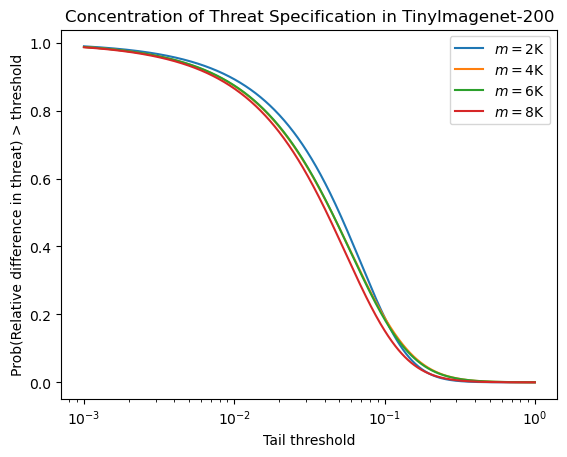

In [115]:
plt.figure()
for per_label_index in range(len(per_label_array)):
    if per_label_index == 4: 
        continue 
    per_label = per_label_array[per_label_index]
    print("For per-label - " + str(per_label))
    plt.plot(
        relative_diff_thresholds[per_label][0:],
        relative_diff_probs[per_label][0:],
        label=r"$m=$" + human_format(200 * per_label),
    )
plt.xscale("log")
plt.xlabel("Tail threshold")
plt.ylabel("Prob(Relative difference in threat) > threshold")
plt.title("Concentration of Threat Specification in TinyImagenet-200")
plt.legend()
plt.show()

In [116]:
min_threat_probs = dict()
min_threat_thresholds = dict()

for per_label_index in range(len(per_label_array)):
    per_label = per_label_array[per_label_index]
    min_threat_probs[per_label], min_threat_thresholds[per_label] = compute_prob(
        torch.flatten(min_threat[per_label_index], start_dim=0), tail=False
    )

    print(min_threat_probs[per_label].shape)
    print("Thresholds are")
    print(min_threat_thresholds[per_label][:15])
    print("Probabilities are")
    print(min_threat_probs[per_label][:15])

torch.Size([100])
Thresholds are
tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500])
Probabilities are
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-04,
        4.0000e-04, 4.0000e-04, 7.0000e-04])
torch.Size([100])
Thresholds are
tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500])
Probabilities are
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-04, 1.0000e-04, 2.0000e-04])
torch.Size([100])
Thresholds are
tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500])
Probabilities are
tensor([0.0000e+00, 0.0000

For per-label - 10
For per-label - 20
For per-label - 30
For per-label - 40
For per-label - 50


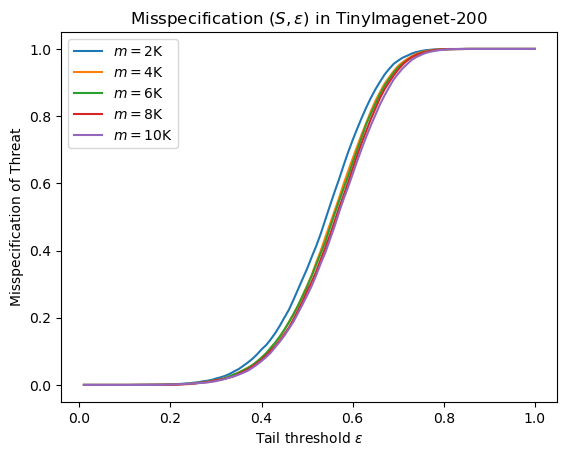

In [118]:
plt.figure()
for per_label_index in range(len(per_label_array)):
    #if per_label_index == 4:
    #    continue 
    per_label = per_label_array[per_label_index]
    print("For per-label - " + str(per_label))
    plt.plot(
        min_threat_thresholds[per_label],
        min_threat_probs[per_label],
        label=r"$m=$" + human_format(200 * per_label),
    )
# plt.xscale('log')
plt.xlabel("Tail threshold " + r"$\epsilon$")
plt.ylabel("Misspecification of Threat")
plt.title("Misspecification " + r"$(S,\epsilon)$" + " in TinyImagenet-200")
plt.legend()
plt.show()